In [9]:
# Import der notwenigen Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [10]:
# Funktionen
def zscore(series):
    return (series - series.mean()) / (np.std(series))

## Daten laden

In [11]:
# Daten laden
df_kunden = pd.read_csv("kunden.csv", sep=";", decimal=".")
df_besucher = pd.read_csv("besucher.csv", sep=";", decimal=".")
txt_geo = pd.read_table("geo.txt")

## Datenbereinigung Besucherdatei

In [12]:
df_besucher.head()

,Alter,Einkommen,Geschlecht,Zeit,KundeNr
0,30,"39919,0953348874",0,"29,0",K1814
1,41,"53430,67308587748",0,"27,0",K1544
2,64,"73163,2169267002",0,"32,0",K1945
3,41,"36761,482581315344",0,"44,0",K1825
4,35,"42684,33163178136",1,"33,0",K1144


In [13]:
df_besucher.dtypes

Alter          int64
Einkommen     object
Geschlecht     int64
Zeit          object
KundeNr       object
dtype: object

In [14]:
# Geringer Abstand zwischen Mean und Median (50%) deutet darauf hin, dass es wahrscheinlich nicht viele signifikante Ausreißer gibt 
df_besucher.describe()

,Alter,Geschlecht
count,891.000000,891.000000
mean,49.881033,0.578002
std,11.865889,0.494156
min,30.000000,0.000000
25%,40.000000,0.000000
50%,49.000000,1.000000
75%,60.000000,1.000000
max,70.000000,1.000000


In [15]:
# Erkanntes Problem: Die Zahlen in der Besucherdatei werden von einem Komma und nicht einem Punkt getrennt 
# Außerdem liegen die Spalten Zeit und Einkommen im String-Format vor
# mit replace führen wir den Austausch von , zu . durch und speichern dann als float 

df_besucher['Zeit'] = df_besucher['Zeit'].str.replace(',', '.').astype(float)
df_besucher['Einkommen'] = df_besucher['Einkommen'].str.replace(',', '.').astype(float)


In [16]:
# Die Änderungen wurden nun übernommen
df_besucher.head()

,Alter,Einkommen,Geschlecht,Zeit,KundeNr
0,30,39919.095335,0,29.0,K1814
1,41,53430.673086,0,27.0,K1544
2,64,73163.216927,0,32.0,K1945
3,41,36761.482581,0,44.0,K1825
4,35,42684.331632,1,33.0,K1144


In [17]:
# Zsore für die Suche nach Ausreißern bestimmen

df_besucher["Alter_zscore"] = zscore(df_besucher.Alter)
df_besucher["Einkommen_zscore"] = zscore(df_besucher.Einkommen)
df_besucher["Zeit_zscore"] = zscore(df_besucher.Zeit)

In [18]:
# Mit der query Methode alle Zeilen nach Zscore > / < 3 Standardabweichungen filtern
df_besucher.query("Alter_zscore > 3")

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Zeit_zscore


In [19]:
df_besucher.query("Alter_zscore < -3")

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Zeit_zscore


In [20]:
df_besucher.query("Einkommen_zscore > 3")

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Zeit_zscore
44,69,108569.087021,1,47.0,K1467,1.61216,3.045514,1.130167


In [21]:
df_besucher.query("Einkommen_zscore < -3")

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Zeit_zscore
265,31,10802.033307,1,25.0,K1561,-1.592096,-3.006193,-0.970889


In [22]:
df_besucher.query("Zeit_zscore > 3")

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Zeit_zscore
603,62,84204.706728,1,68.0,K1526,1.021902,1.537377,3.135722


In [23]:
df_besucher.query("Zeit_zscore < -3")

,Alter,Einkommen,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Zeit_zscore
158,31,38298.533652,1,3.0,K1623,-1.592096,-1.30418,-3.071946


In [24]:
# Zeigt die fehlenden Werte je Zeile in Prozent an
df_besucher.isna().mean()

Alter               0.0
Einkommen           0.0
Geschlecht          0.0
Zeit                0.0
KundeNr             0.0
Alter_zscore        0.0
Einkommen_zscore    0.0
Zeit_zscore         0.0
dtype: float64

In [25]:
# Ausreißer und NaNs mit Median ersetzen (Median um unanfälliger gegenüber Ausreißern zu sein als bei Durchschnitt)

ersetz_eink = [44, 265] # Zu ersetzende Indexpositionen  
ersetz_zeit = [603, 158]

# Mit loc Funktion Index und Spalte angeben und dann mit Median ersetzen
df_besucher.loc[ersetz_eink, 'Einkommen'] = df_besucher.Einkommen.median()
df_besucher.loc[ersetz_zeit, 'Zeit'] = df_besucher.Zeit.median()
#df_besucher.Geschlecht.fillna(df_besucher.Geschlecht.median(), inplace=True)

In [26]:
# Zscore Spalten werden nicht mehr benötigt und können gelöscht werden
df_besucher.drop(columns=["Alter_zscore", "Einkommen_zscore", "Zeit_zscore"], inplace=True)

## Datenbereinigung Kundendatei

In [27]:
df_kunden.head()

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr
0,64,66894.0,88160.31,1.0,43.0,K0310
1,54,77644.0,103145.70,1.0,40.0,K1042
2,55,44341.0,80565.16,0.0,37.0,K0382
3,49,67271.0,83949.89,0.0,42.0,K0498
4,46,49832.0,93781.58,0.0,41.0,K0552


In [28]:
df_kunden.dtypes

Alter           int64
Einkommen     float64
Preis         float64
Geschlecht    float64
Zeit          float64
KundeNr        object
dtype: object

In [29]:
df_kunden.describe()

,Alter,Einkommen,Preis,Geschlecht,Zeit
count,1104.000000,1.104000e+03,1104.000000,1099.000000,1104.000000
mean,50.481884,9.644748e+05,88975.198714,0.637853,44.375906
std,12.225059,3.009470e+07,24464.067781,0.480840,10.848040
min,30.000000,-6.284037e+04,21471.650000,0.000000,12.000000
25%,40.000000,4.663850e+04,70609.422500,0.000000,37.000000
50%,51.000000,5.901300e+04,88931.455000,1.000000,44.000000
75%,61.000000,7.029800e+04,107093.375000,1.000000,52.000000
max,120.000000,1.000000e+09,165482.310000,1.000000,80.000000


In [30]:
# Zscore für Ausreißer

df_kunden["Alter_zscore"] = zscore(df_kunden.Alter)
df_kunden["Einkommen_zscore"] = zscore(df_kunden.Einkommen)
df_kunden["Preis_zscore"] = zscore(df_kunden.Preis)
df_kunden["Zeit_zscore"] = zscore(df_kunden.Zeit)

In [31]:
df_kunden.query("Alter_zscore > 3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore
142,100,88749.0,119134.23,0.0,64.0,K0494,4.052378,-0.029112,1.233348,1.809819
711,120,61857.0,104214.07,1.0,52.0,K0039,5.689103,-0.030006,0.623191,0.703127


In [32]:
df_kunden.query("Alter_zscore < -3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [33]:
df_kunden.query("Alter < 0")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [34]:
df_kunden.query("Einkommen_zscore > 3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore
408,68,1.000000e+09,87209.72,0.0,52.0,K0701,1.433617,33.211439,-0.072199,0.703127


In [35]:
df_kunden.query("Einkommen_zscore < -3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [36]:
df_kunden.query("Einkommen < 0")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore
1082,59,-62840.374523,92837.59,0.0,46.0,K1083,0.697091,-0.034152,0.157952,0.149781


In [37]:
df_kunden.query("Preis_zscore > 3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore
834,68,107689.0,165482.31,1.0,60.0,K0415,1.433617,-0.028483,3.128743,1.440922


In [38]:
df_kunden.query("Preis_zscore < -3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [39]:
df_kunden.query("Preis < 0")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [40]:
df_kunden.query("Zeit_zscore > 3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore
313,62,96569.0,140745.65,0.0,80.0,K0249,0.9426,-0.028852,2.117142,3.285408


In [41]:
df_kunden.query("Zeit_zscore < -3")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [42]:
df_kunden.query("Zeit < 0")

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Alter_zscore,Einkommen_zscore,Preis_zscore,Zeit_zscore


In [43]:
# Zeigt die fehlenden Werte je Zeile in Prozent an
df_kunden.isna().mean()

Alter               0.000000
Einkommen           0.000000
Preis               0.000000
Geschlecht          0.004529
Zeit                0.000000
KundeNr             0.000000
Alter_zscore        0.000000
Einkommen_zscore    0.000000
Preis_zscore        0.000000
Zeit_zscore         0.000000
dtype: float64

In [44]:
# Ausreißer und NaNs durch Median ersetzen - gleiches Vorgehen wie davor

ersetz_alter_2 = [142, 711]
ersetz_einkommen_2 = [408, 1082]
ersetzZeit_2 = 313
ersetzPreis_2 = 834

df_kunden.loc[ersetz_alter_2, 'Alter'] = df_kunden.Alter.median()
df_kunden.loc[ersetz_einkommen_2, 'Einkommen'] = df_kunden.Einkommen.median()
df_kunden.loc[ersetzZeit_2, 'Zeit'] = df_kunden.Zeit.median()
df_kunden.loc[ersetzPreis_2, 'Preis'] = df_kunden.Preis.median()

df_kunden.Geschlecht.fillna(df_kunden.Geschlecht.median(), inplace=True)

In [45]:
df_kunden.Einkommen.median()

59013.0

In [46]:
# Zscore Spalten wieder entfernen
df_kunden.drop(columns=["Alter_zscore", "Einkommen_zscore", "Preis_zscore", "Zeit_zscore"], inplace=True)

In [47]:
df_kunden.head()

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr
0,64,66894.0,88160.31,1.0,43.0,K0310
1,54,77644.0,103145.70,1.0,40.0,K1042
2,55,44341.0,80565.16,0.0,37.0,K0382
3,49,67271.0,83949.89,0.0,42.0,K0498
4,46,49832.0,93781.58,0.0,41.0,K0552


## Datenbereinigung Geodatei

In [48]:
txt_geo.head()

,KundeNr,Niederlassung
0,K0001,Sachsen
1,K0002,NRW
2,K0003,Hessen
3,K0004,Bayern
4,K0005,Bayern


In [49]:
# Die Datei enthält zwei Spalten, jeweils Strings
txt_geo.dtypes

KundeNr          object
Niederlassung    object
dtype: object

In [50]:
# Testen, welche Bundesländer es gibt und welche Ungereimtheiten auftreten

print(txt_geo.Niederlassung.unique())
print("Einzigartige Einträge: " + str(txt_geo.Niederlassung.nunique()))

['Sachsen' 'NRW' 'Hessen' 'Bayern' 'Baden-Württemberg'
 'Nordrhein-Westfalen' 'Berlin' 'Niedersachsen' 'Brandenburg' 'Thüringen'
 'Hamburg' 'Düsseldorf' 'Berlin-Charlottenburg' 'Berlin-Mitte' 'BERLIN']
Einzigartige Einträge: 15


In [51]:
# Einheitliches Format erzeugen 

txt_geo.Niederlassung.replace({'NRW': 'Nordrhein-Westfalen',
                            'Berlin-Charlottenburg': 'Berlin',
                            'Berlin-Mitte': 'Berlin',
                            'BERLIN': 'Berlin'}, inplace=True)

In [52]:
# Testen, ob die Korrekturen durchgeführt wurden
# Zuvor gab es 14 einzigartige Bundesländer, jetzt noch 11. Das ist korrekt. 
print("Einzigartige Einträge: " + str(txt_geo.Niederlassung.nunique()))

Einzigartige Einträge: 11


# Daten in einen Dataframe zusammenfügen

In [53]:
# Merge der Datensätze Kunden und Besucher
df1 = pd.merge(df_kunden, df_besucher, on=['KundeNr', 'Alter', 'Einkommen', 'Geschlecht', 'Zeit'], how='outer') #Methode outer, da ungleich lang und alle Daten behalten werden sollen
# Für df_final ebenfalls die Standortdatei txt_geo hinzufügen
df_final = pd.merge(df1, txt_geo, on='KundeNr', how='inner') # Methode inner, da nur die Zeilen, wo KundenNr übereinstimmt behalten werden sollen 

In [54]:
df1.head()

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr
0,64,66894.0,88160.31,1.0,43.0,K0310
1,54,77644.0,103145.70,1.0,40.0,K1042
2,55,44341.0,80565.16,0.0,37.0,K0382
3,49,67271.0,83949.89,0.0,42.0,K0498
4,46,49832.0,93781.58,0.0,41.0,K0552


In [55]:
# Anhand beispielhafter KundenNr aus Besucher-Datensatz prüfen, ob die Daten richtig übertragen wurden
df_besucher.query("KundeNr == 'K1945'") # Da es sich um String handelt, wird die Kundennr in weitere Anführungszeichen genommen 

,Alter,Einkommen,Geschlecht,Zeit,KundeNr
2,64,73163.216927,0,32.0,K1945


In [56]:
# Wurde übernommen 
df1.query("KundeNr == 'K1945'") 

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr
1106,64,73163.216927,NaN,0.0,32.0,K1945


In [57]:
# Übersicht finaler Dataframe
df_final.head()

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Niederlassung
0,64,66894.0,88160.31,1.0,43.0,K0310,Bayern
1,54,77644.0,103145.70,1.0,40.0,K1042,Berlin
2,55,44341.0,80565.16,0.0,37.0,K0382,Baden-Württemberg
3,49,67271.0,83949.89,0.0,42.0,K0498,Bayern
4,46,49832.0,93781.58,0.0,41.0,K0552,Hessen


In [58]:
# Überprüfen ob die richtigen Datenformate vorliegen
# Nur die Spalten KundeNr und Niederlassung sind strings, was korrekt ist
df_final.dtypes

Alter              int64
Einkommen        float64
Preis            float64
Geschlecht       float64
Zeit             float64
KundeNr           object
Niederlassung     object
dtype: object

In [59]:
# Nach NaNs gucken - Wie erwartet fehlen nur in Preisspalte einige Einträge (aus Besucherdatei)
df_final.isna().mean()

Alter            0.000000
Einkommen        0.000000
Preis            0.446617
Geschlecht       0.000000
Zeit             0.000000
KundeNr          0.000000
Niederlassung    0.000000
dtype: float64

## Explorative Datenanalyse

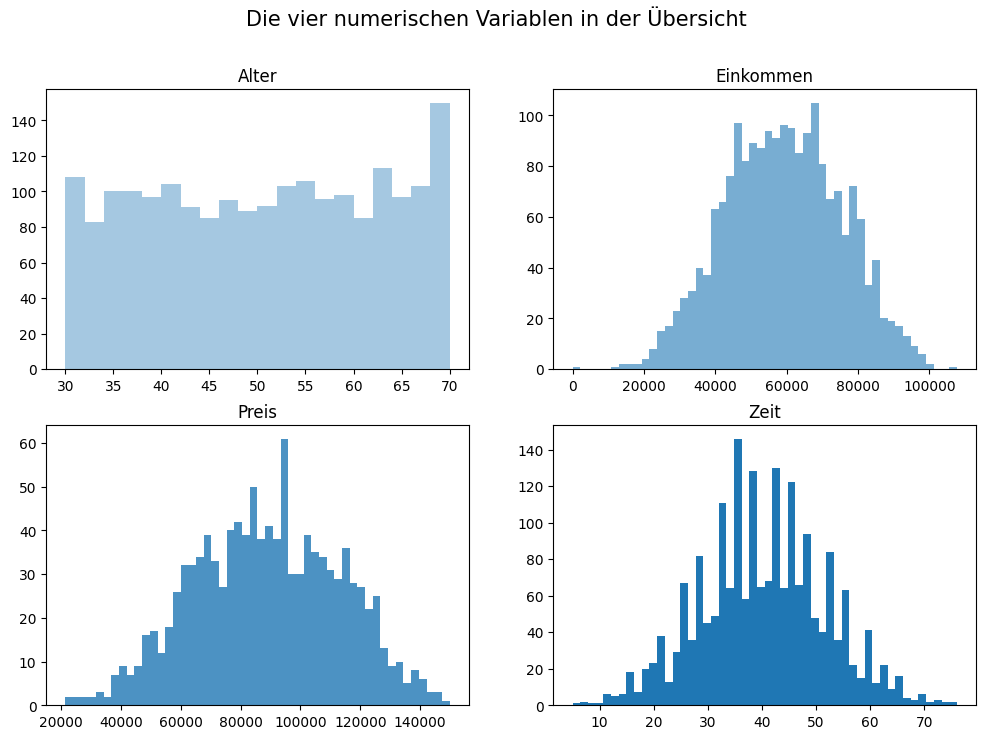

In [60]:
# Die vier numerischen Variablen Alter, Einkommen, Preis und Zeit als Histogramm dargestellen
# Auffälig: Die Datenreihen Preis, Einkommen und Zeit weisen eine Verteilung auf die an die Normalverteilung erinnert
# Das könnte für spätere statistische Analyseverfahren von Bedeutung sein 

fig, axes = plt.subplots(2,2)

(ax1, ax2), (ax3, ax4) = axes

ax1.hist(x=df_final.Alter, bins=20, alpha=0.4)
ax1.set_title("Alter")

ax2.hist(x=df_final.Einkommen, bins=50, alpha=0.6)
ax2.set_title("Einkommen")

ax3.hist(x=df_final.Preis, bins=50, alpha=0.8)
ax3.set_title("Preis")

ax4.hist(x=df_final.Zeit, bins=50)
ax4.set_title("Zeit")

plt.suptitle("Die vier numerischen Variablen in der Übersicht", fontsize=15)
plt.show()

# Aufgaben 

## N1: Wie viele Autos wurden verkauft?

In [61]:
# Nur bei Verkäufen existiert ein Eintrag in der Preisspalte, weswegen wir einfach mit .count() arbeiten können
print(df_final.Preis.count())

1104


## N2: Was ist der Höchst-, Mindest- und Durchschnittspreis der verkauften Autos?

In [62]:
# Verwendung von max-, min- und mean-Funktion - angewendet auf die Preisspalte
print("Höchstpreis: " + str(df_final.Preis.max().round(2)))
print("Mindestpreis: " + str(df_final.Preis.min().round(2)))
print("Durchschnittspreis: " + str(df_final.Preis.mean().round(2)))

Höchstpreis: 149827.25
Mindestpreis: 21471.65
Durchschnittspreis: 88905.86


## N3: Wie hoch war der Gesamtumsatz

In [63]:
# Die Preisspalte aufsummieren
print("Gesamtumsatz: " + str(df_final.Preis.sum().round(2)))

Gesamtumsatz: 98152068.52


## N4: Wie viele Autos wurden pro Bundesland verkauft?

In [64]:
# Nach Niederlassungen gruppieren, danach zählen 
df_numbers = df_final.groupby(df_final.Niederlassung).count()
df_numbers = df_numbers.Preis
print(df_numbers)

Niederlassung
Baden-Württemberg      205
Bayern                 188
Berlin                 126
Brandenburg             37
Düsseldorf               1
Hamburg                 43
Hessen                  96
Niedersachsen           96
Nordrhein-Westfalen    174
Sachsen                 89
Thüringen               49
Name: Preis, dtype: int64


In [65]:
# Beispielhaft anhand von Sachsen die vorherige Auflistung verifizieren
# Bei Preis existieren 89 Einträge wie auch oben, also korrekt!
df_final.query("Niederlassung == 'Sachsen'").count()

Alter            162
Einkommen        162
Preis             89
Geschlecht       162
Zeit             162
KundeNr          162
Niederlassung    162
dtype: int64

## N5: Wie hoch war der durchschnittliche Umsatz pro Bundesland?

In [66]:
# Nach Niederlassung gruppieren, dann den Durchschnitt des Preises nehmen, die Werte absteigend sortieren und runden
df_final.groupby(df_final.Niederlassung) \
    .Preis.mean() \
    .sort_values() \
    .round(2)

Niederlassung
Hamburg                 85549.50
Hessen                  85864.93
Brandenburg             86673.64
Niedersachsen           87165.91
Nordrhein-Westfalen     88451.76
Bayern                  89344.31
Sachsen                 89455.08
Berlin                  89584.98
Thüringen               90816.99
Baden-Württemberg       90969.56
Düsseldorf             120215.50
Name: Preis, dtype: float64

Text(0, 0.5, 'Umsatz')

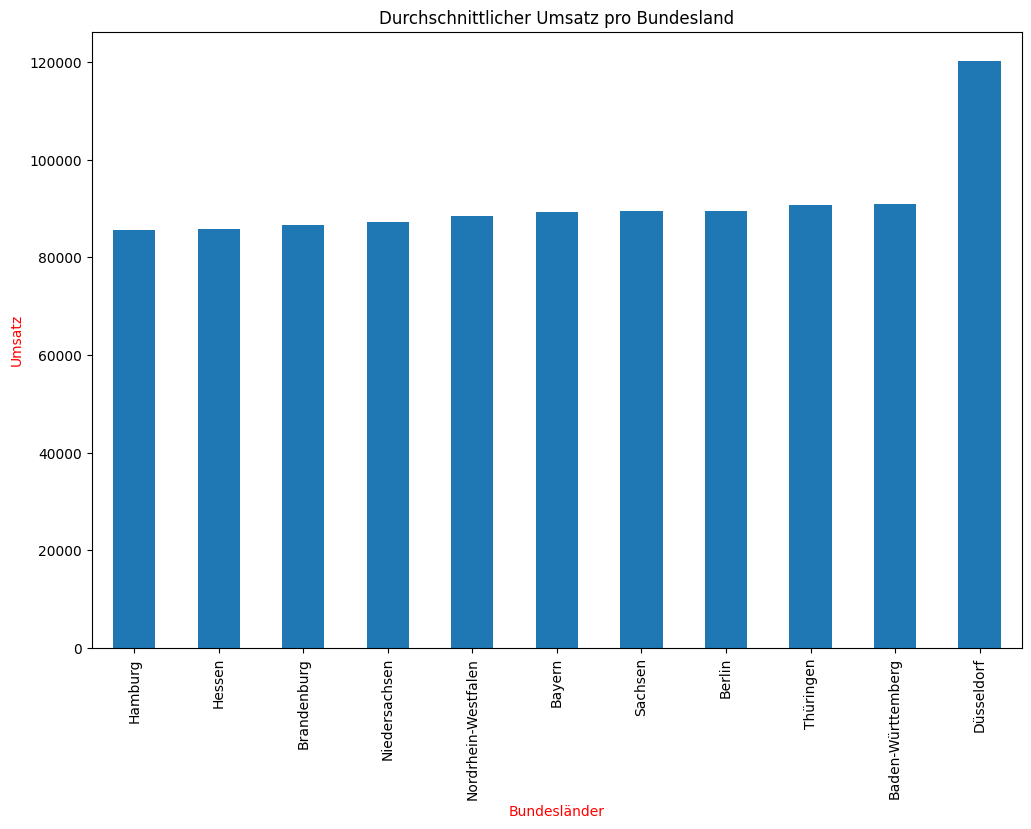

In [67]:
# Barplot der Ergebnisse erstellen. 

avg_umsatz = df_final.groupby(df_final.Niederlassung) \
    .Preis.mean() \
    .sort_values() \
    .round(2).plot(kind="bar", title="Durchschnittlicher Umsatz pro Bundesland")
plt.xlabel("Bundesländer", color="r")
plt.ylabel("Umsatz", color="r")

# Düsseldorf ist Spitzenreiter und sticht deutlich hervor
# Das erregt den Verdacht, das der dortige Standort größer, über ein besonderes Angebot verfügt oder das beste Marketing betreibt


## N6: In welchem Bundesland wurde das teuerste Auto verkauft?

In [68]:
# Nach Niederlassung gruppieren, dann die Preis-Spalte auswählen, das Maximum bestimmen und nur das erste Element auswählen
df_final.groupby(df_final.Niederlassung).Preis.max().head(1)

Niederlassung
Baden-Württemberg    144045.32
Name: Preis, dtype: float64